In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

In [53]:
def clean_and_analyze_data(df, dataset_name):
    print(f"\n========== {dataset_name} DATASET ==========")

    print("Initial Shape:", df.shape)

    print("\nNull values before cleaning:")
    print(df.isnull().sum())

    df = df.dropna()
    print("\nShape after removing null values:", df.shape)

    dup_rows = df.duplicated().sum()
    print("\nDuplicate rows found:", dup_rows)

    df = df.drop_duplicates()
    print("Shape after removing duplicate rows:", df.shape)

    dup_cols = df.columns[df.columns.duplicated()]
    print("\nDuplicate columns:", list(dup_cols))

    df = df.loc[:, ~df.columns.duplicated()]

    print("\nFinal Dataset Info:")
    print(df.info())

    return df


In [54]:
hour_df = pd.read_csv("hour.csv")
hour_df = clean_and_analyze_data(hour_df, "HOUR")


========== HOUR DATASET ==========
Initial Shape: (17379, 17)

Null values before cleaning:
instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Shape after removing null values: (17379, 17)

Duplicate rows found: 0
Shape after removing duplicate rows: (17379, 17)

Duplicate columns: []

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     173

In [55]:
X = hour_df.drop(columns=[
    'instant', 'casual', 'registered', 'yr', 'dteday'
])
y = hour_df['cnt']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [89]:
param_grid = {
    'n_estimators': [5, 15, 17],
    'max_depth': [2, 8, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

In [90]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [91]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 8, 8], 'n_estimators': [5, 15, 17],
                         'subsample': [0.7, 1]},
             scoring='r2', verbose=1)

In [92]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 17, 'subsample': 0.7}
Best CV R² Score: 0.8274820284894169


In [93]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nHOUR DATASET - XGBRegressor PERFORMANCE AFTER CLEANING & TUNING")
print(f"Training R² Score : {train_r2:.4f}")
print(f"Training RMSE     : {train_rmse:.2f}")
print(f"Test R² Score     : {test_r2:.4f}")
print(f"Test RMSE         : {test_rmse:.2f}")
print(f"Test MAE          : {test_mae:.2f}")


HOUR DATASET - XGBRegressor PERFORMANCE AFTER CLEANING & TUNING
Training R² Score : 0.9190
Training RMSE     : 0.40
Test R² Score     : 0.8646
Test RMSE         : 0.52
Test MAE          : 0.42


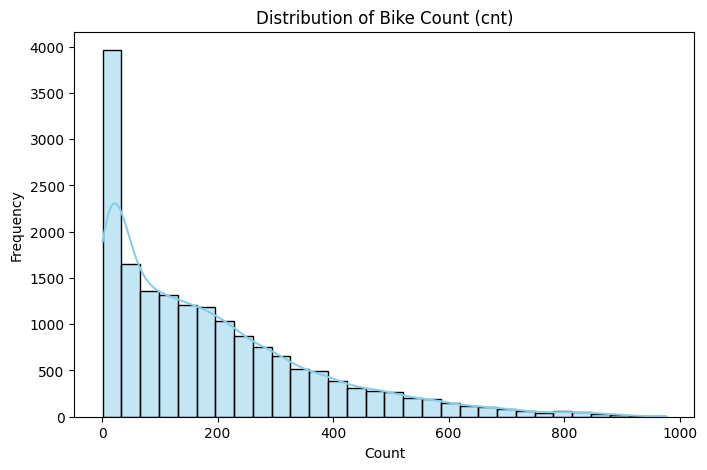

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(hour_df['cnt'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Bike Count (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

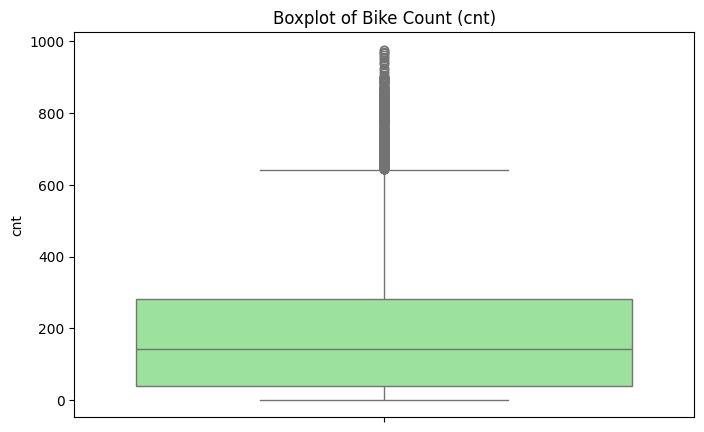

In [64]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=hour_df['cnt'], color='lightgreen')
plt.title("Boxplot of Bike Count (cnt)")
plt.show()

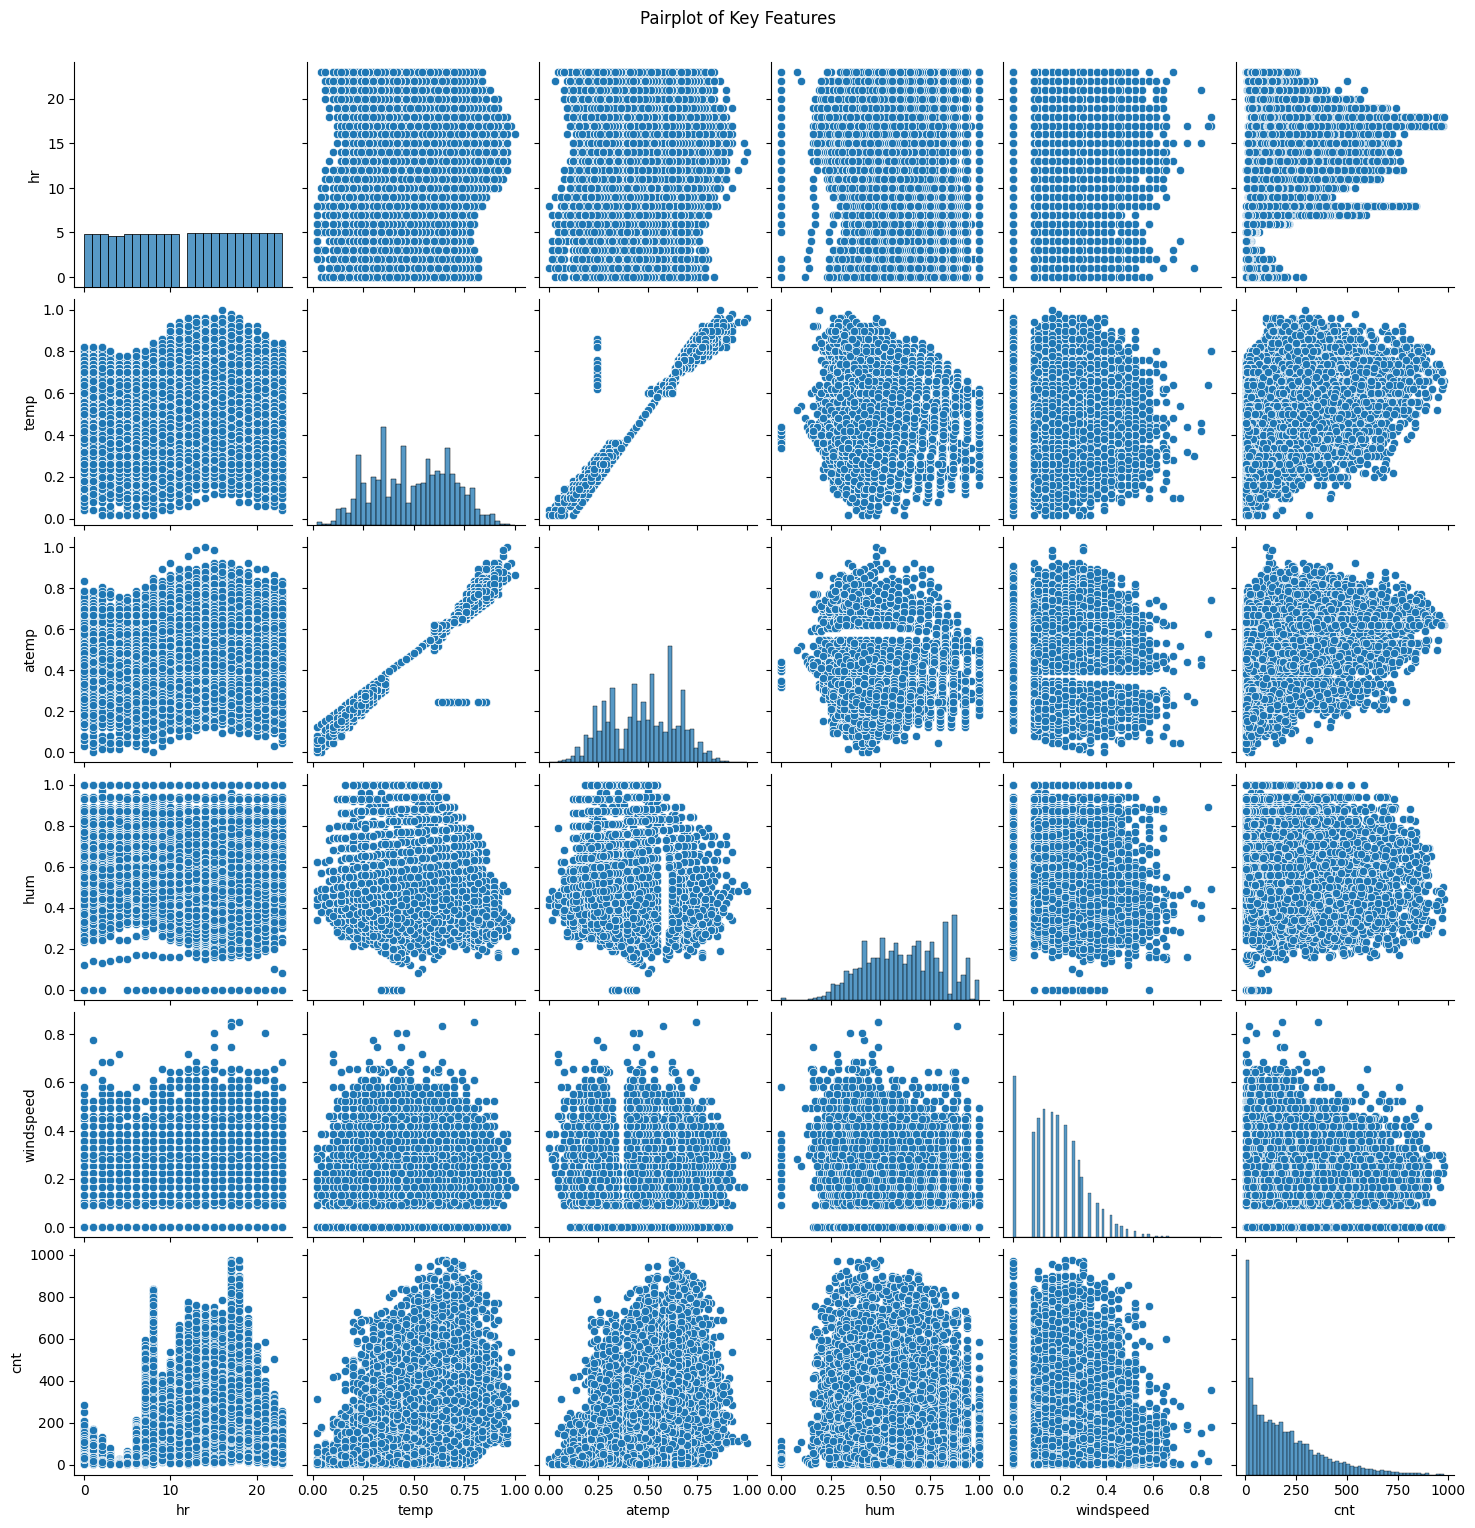

In [65]:
features = ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(hour_df[features])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

In [66]:
hour_feature_cols = [
    "season", "mnth", "hr", "holiday",
    "weekday", "workingday", "weathersit",
    "temp", "atemp", "hum", "windspeed"
]

In [67]:
def recursive_forecast_hour(model, input_df, steps=6):
    """
    Recursive forecasting for HOUR dataset (hourly basis)
    """
    predictions = []
    current_input = input_df.copy()

    for step in range(steps):
        pred = model.predict(current_input)[0]
        predictions.append(pred)

        # Increment hour safely (0–23)
        if "hr" in current_input.columns:
            current_input["hr"] = (current_input["hr"] + 1) % 24

        # Rotate weekday after 24 hours
        if "weekday" in current_input.columns and current_input["hr"].iloc[0] == 0:
            current_input["weekday"] = (current_input["weekday"] + 1) % 7

    return predictions

In [68]:
def predict_next_hours(model, user_input, feature_cols, hours=6):
    """
    Predict next hours for HOUR dataset
    """
    input_df = pd.DataFrame([user_input])[feature_cols]

    preds = recursive_forecast_hour(
        model=model,
        input_df=input_df,
        steps=hours
    )

    start_hr = user_input["hr"]

    hour_labels = [
        f"Hour {(start_hr + i) % 24}"
        for i in range(hours)
    ]

    result_df = pd.DataFrame({
        "Time": hour_labels,
        "Predicted Bike Rentals (cnt)": np.round(preds, 2)
    })

    result_df.index = [""] * len(result_df)
    return result_df


In [69]:
hour_input = {
    "season": 1,
    "mnth": 1,
    "hr": 10,            # 10 AM
    "holiday": 0,
    "weekday": 2,        # Tuesday
    "workingday": 1,
    "weathersit": 2,
    "temp": 0.344167,
    "atemp": 0.363625,
    "hum": 0.805833,
    "windspeed": 0.160446
}


In [70]:
X = hour_df.drop(columns=[
    'instant', 'casual', 'registered', 'yr', 'dteday', 'cnt'
])
y = hour_df['cnt']


In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [75]:
print("Model trained with features:")
print(best_model.get_booster().feature_names)

Model trained with features:
['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [76]:
print("\n========== HOURLY FORECAST (NEXT 6 HOURS) ==========\n")

hourly_forecast = predict_next_hours(
    model=best_model,
    user_input=hour_input,
    feature_cols=hour_feature_cols,
    hours=6
)

print(hourly_forecast)




========== HOURLY FORECAST (NEXT 6 HOURS) ==========

     Time  Predicted Bike Rentals (cnt)
  Hour 10                        156.25
  Hour 11                        156.25
  Hour 12                        156.25
  Hour 13                        156.25
  Hour 14                        156.25
  Hour 15                        156.25


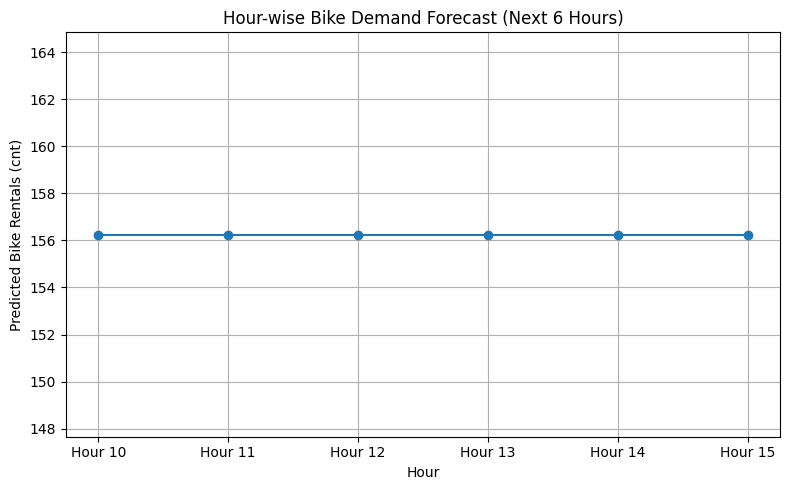

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(
    hourly_forecast["Time"],
    hourly_forecast["Predicted Bike Rentals (cnt)"],
    marker='o'
)

plt.title("Hour-wise Bike Demand Forecast (Next 6 Hours)")
plt.xlabel("Hour")
plt.ylabel("Predicted Bike Rentals (cnt)")
plt.grid(True)
plt.tight_layout()
plt.show()


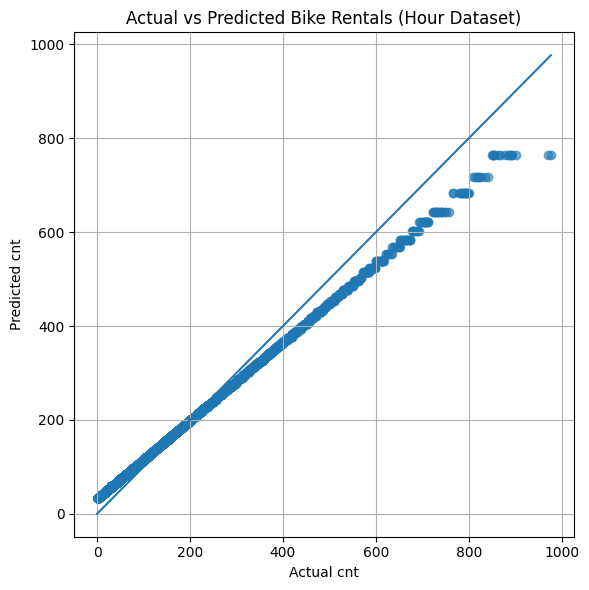

In [78]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_test_pred, alpha=0.6)

# Perfect prediction line
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([0, max_val], [0, max_val])

plt.title("Actual vs Predicted Bike Rentals (Hour Dataset)")
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
pip install numpy pandas scikit-learn xgboost lightgbm

In [88]:
# =====================================================
# Final Corrected Performance Comparison - Hour Dataset
# =====================================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# -----------------------------
# Load Dataset
# -----------------------------
data = pd.read_csv("hour.csv")

# -----------------------------
# Feature Engineering (CRITICAL)
# -----------------------------

# Create time index for temporal order
data["time_index"] = np.arange(len(data))

# Drop leakage / non-numeric columns
data.drop(columns=["dteday", "instant", "casual", "registered"], inplace=True)

# Log transform target
y = np.log1p(data["cnt"])
X = data.drop("cnt", axis=1)

# -----------------------------
# Time-based Split (80% / 20%)
# -----------------------------
split_index = int(len(data) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# -----------------------------
# Models (Proper Scaling via Pipeline)
# -----------------------------
models = {
    "Linear Regression": LinearRegression(),

    "Ridge Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),

    "Lasso Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(alpha=0.001, max_iter=20000))
    ]),

    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000))
    ]),

    "KNN Regressor": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=7))
    ]),

    "SVR (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf", C=100, gamma="scale"))
    ]),

    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
}

# -----------------------------
# Evaluation Function (Original Scale)
# -----------------------------
def get_metrics(y_train, train_pred, y_test, test_pred):

    # Convert back from log scale
    y_train_actual = np.expm1(y_train)
    y_test_actual = np.expm1(y_test)
    train_pred_actual = np.expm1(train_pred)
    test_pred_actual = np.expm1(test_pred)

    return [
        np.sqrt(mean_squared_error(y_train_actual, train_pred_actual)),
        np.sqrt(mean_squared_error(y_test_actual, test_pred_actual)),
        mean_absolute_error(y_train_actual, train_pred_actual),
        mean_absolute_error(y_test_actual, test_pred_actual),
        r2_score(y_train_actual, train_pred_actual),
        r2_score(y_test_actual, test_pred_actual)
    ]

# -----------------------------
# Train & Evaluate
# -----------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    results.append([name] + get_metrics(y_train, train_pred, y_test, test_pred))

# -----------------------------
# Results Table
# -----------------------------
columns = [
    "Model",
    "Train RMSE", "Test RMSE",
    "Train MAE", "Test MAE",
    "Train R²", "Test R²"
]

performance_df = pd.DataFrame(results, columns=columns)

print("\n✅ Final Performance Comparison: Hour Dataset (Corrected)\n")
print(performance_df)



✅ Final Performance Comparison: Hour Dataset (Corrected)

               Model  Train RMSE    Test RMSE  Train MAE     Test MAE  \
0  Linear Regression  149.902078   203.043351  99.787599   139.830955   
1   Ridge Regression  149.897474   203.038639  99.785792   139.830290   
2   Lasso Regression  149.779947   203.089721  99.748543   139.909392   
3         ElasticNet  149.816023   203.024649  99.765350   139.866325   
4      KNN Regressor   92.196226   178.168323  55.147809   114.834086   
5   SVR (RBF Kernel)   99.508321  6176.947837  50.225383  2020.393156   
6      Random Forest   22.375625    76.773331  13.070975    49.617356   
7  Gradient Boosting   40.276925    90.884873  24.762099    58.396546   
8            XGBoost   30.717463    75.672339  18.704183    49.018732   
9           LightGBM   33.149670    81.981123  19.983147    52.785961   

   Train R²     Test R²  
0  0.193795    0.151953  
1  0.193844    0.151992  
2  0.195108    0.151565  
3  0.194720    0.152109  
4  0.69

In [94]:
import joblib
import os

# Create models directory
os.makedirs("models", exist_ok=True)

# Save HOUR model
joblib.dump(best_model, "models/bike_hour_demand_model.pkl")

print("✅ Hour model saved successfully")


✅ Hour model saved successfully
